In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import warnings
import random
warnings.filterwarnings('ignore')
import transformers
from models.bert import BertAITextDetector
from models.roberta_model import RobertaAITextDetector
from models.gpt import GPTAITextDetector
from models.xlm import XLMRobertaAITextDetector
from utils.dataloader import AITextDataset
import numpy as np
from transformers import AdamW
from tqdm import tqdm
from torch.utils.data import DataLoader,Subset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,roc_curve,auc,accuracy_score

In [2]:
# Enforce reproducibility
seed = 25
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True

In [16]:
def training_loop(epochs,dataloader,val_dataloader,model,loss_fn,optimizer,scheduler):
    model.train()
    train_loss = []
    val_loss =[]
    for  epoch in range(1,epochs+1):       
        loop=tqdm(enumerate(dataloader),leave=False,total=len(dataloader))
        total_loss  = 0
        num_correct = 0
        target_count = 0
        for batch, dl in loop:
            ids=dl['ids'].to(device)
            if arch =='bert':
                token_type_ids = dl['token_type_ids'].to(device)
            mask= dl['mask'].to(device)
            label=dl['target'].to(device)
            label = label.unsqueeze(1).to(device)

            optimizer.zero_grad()
            
            if arch =='bert':
                output = model(ids,mask,token_type_ids)
            else:
                output = model(ids,mask)
            label = label.type_as(output)

            loss = loss_fn(output,label)
            # back propagate
            loss.backward()  
            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)          
            optimizer.step()
            scheduler.step()
            
            output = output.cpu().detach().numpy()
            pred = np.where(output >= 0, 1, 0)

            target_count += label.size(0)
            
            # compute accuracy per batch
            num_correct+= sum(1 for a, b in zip(pred, label) if a[0] == b[0]) 
              
          
            total_loss+= loss.item() 
        train_loss.append(round(float(total_loss/len(dataloader)),3))
        print(f'Training loss :{round(float(total_loss/len(dataloader)),3)}   with accuracy {round(float(100 * num_correct /target_count),3)}%')
        if epoch%1 == 0 and epoch>=40:
           val_acc, v_loss = validation_loop(val_dataloader,model,loss_fn)   
           val_loss.append(v_loss)
           # Show progress while training
           loop.set_description(f'Epochs={epoch}/{epochs}')
           # saved model 
           torch.save(model.state_dict(), PATH+'/ai-text-classifier-'+str(val_acc)+'.pth')
            

    return model, train_loss,val_loss



In [18]:
def validation_loop(dataloader,model,loss_fn):
    model.eval()
    loop = tqdm(enumerate(dataloader),leave=False,total=len(dataloader))
    num_correct = 0
    target_count = 0
    total_loss  = 0
    with torch.no_grad():
        for batch, dl in loop:
            ids=dl['ids'].to(device)
            if arch =='bert':
                token_type_ids=dl['token_type_ids'].to(device)
            mask= dl['mask'].to(device)
            label=dl['target'].to(device)
            label = label.unsqueeze(1).to(device)
            if arch =='bert':
                output = model(ids,mask,token_type_ids)
            else:
                output = model(ids,mask)

            label = label.type_as(output) 
            loss = loss_fn(output,label)               
            output =output.cpu().detach().numpy()
            pred = np.where(output >= 0, 1, 0)
            target_count += label.size(0)
            

            # compute accuracy per batch
            num_correct+= sum(1 for a, b in zip(pred, label) if a[0] == b[0])
            total_loss+= loss.item() 
       
    print(f'Validation loss :{round(float(total_loss/len(dataloader)),3)}   with accuracy {round(float(100 * num_correct /target_count),3)}%')
    return float(100 * num_correct / target_count),round(float(total_loss/len(dataloader)),3)

In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [20]:
model = BertAITextDetector(dropout = 0.20)
#fine tune only fc layer
for param in model.bert.parameters():
    param.requires_grad = False

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
from transformers import AdamW,get_linear_schedule_with_warmup
import torch.nn as nn
import time
PATH ='fc_bert/'
#move model to GPU
max_length =128
model.to(device)
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")
dataset = AITextDataset(tokenizer =tokenizer, max_length = 128, data_type ='train',model_type ='bert',file_path ='dataset/train_set.json')
dataset_size = len(dataset)
validation_split = 0.20
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))

np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
train_split = Subset(dataset, train_indices)

val_split = Subset(dataset, val_indices)
train_dataloader = torch.utils.data.DataLoader(train_split, batch_size=16, shuffle=True, num_workers=4,collate_fn = dataset.collate_fn_train)
val_dataloader = torch.utils.data.DataLoader(val_split, batch_size=16, shuffle=False, num_workers=4,collate_fn= dataset.collate_fn_train)
##Training parameters:
epochs = 50
# construct an optimizer
arch ='bert'
optimizer = AdamW(model.parameters(), lr=2e-4,eps = 1e-08)

# Set up the learning rate scheduler
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps=0, # Default value
                                                num_training_steps=total_steps)
loss_fn = nn.BCEWithLogitsLoss()

training_start_time = time.time()

model,train_loss,val_loss = training_loop(epochs, train_dataloader,val_dataloader, model, loss_fn, optimizer,scheduler)
print('Training finished, took {:.2f}s'.format(time.time() - training_start_time))

torch.save(model.state_dict(), PATH +'/ai-text-'+arch+str(epochs)+'-classifier-max-length-'+str(max_length)+'.pth')

Training loss :0.695   with accuracy 52.875%


Training loss :0.686   with accuracy 55.281%


Training loss :0.678   with accuracy 55.625%


Training loss :0.668   with accuracy 59.406%


Training loss :0.666   with accuracy 59.719%


Training loss :0.663   with accuracy 61.281%


Training loss :0.66   with accuracy 60.5%


Training loss :0.656   with accuracy 60.719%


Training loss :0.654   with accuracy 62.156%


Training loss :0.65   with accuracy 62.094%


Training loss :0.653   with accuracy 61.719%


Training loss :0.649   with accuracy 62.125%


Training loss :0.648   with accuracy 63.594%


Training loss :0.646   with accuracy 62.531%


Training loss :0.643   with accuracy 63.469%


Training loss :0.645   with accuracy 62.938%


Training loss :0.64   with accuracy 63.375%


Training loss :0.64   with accuracy 63.375%


Training loss :0.636   with accuracy 64.031%


Training loss :0.635   with accuracy 63.812%


Training loss :0.636   with accuracy 63.438%


Training loss :0.636   with accuracy 63.938%


Training loss :0.631   with accuracy 64.188%


Training loss :0.632   with accuracy 64.781%


Training loss :0.631   with accuracy 64.469%


Training loss :0.632   with accuracy 64.656%


Training loss :0.629   with accuracy 64.531%


Training loss :0.628   with accuracy 65.469%


Training loss :0.633   with accuracy 64.625%


Training loss :0.629   with accuracy 64.75%


Training loss :0.63   with accuracy 65.0%


Training loss :0.63   with accuracy 65.375%


Training loss :0.627   with accuracy 64.781%


Training loss :0.633   with accuracy 63.875%


Training loss :0.629   with accuracy 65.156%


Training loss :0.633   with accuracy 63.281%


Training loss :0.622   with accuracy 66.875%


Training loss :0.626   with accuracy 64.688%


Training loss :0.623   with accuracy 65.938%


Training loss :0.628   with accuracy 64.312%


Validation loss :0.632   with accuracy 63.875%


Training loss :0.617   with accuracy 65.875%


Validation loss :0.617   with accuracy 67.0%


Training loss :0.613   with accuracy 67.062%


Validation loss :0.614   with accuracy 68.5%


Training loss :0.613   with accuracy 67.531%


Validation loss :0.613   with accuracy 68.125%


Training loss :0.612   with accuracy 67.469%


Validation loss :0.613   with accuracy 68.625%


Training loss :0.612   with accuracy 68.219%


Validation loss :0.613   with accuracy 68.0%


Training loss :0.611   with accuracy 67.344%


Validation loss :0.612   with accuracy 68.5%


Training loss :0.611   with accuracy 67.656%


Validation loss :0.612   with accuracy 68.625%


Training loss :0.611   with accuracy 67.375%


Validation loss :0.612   with accuracy 68.125%


Training loss :0.611   with accuracy 67.438%


Validation loss :0.612   with accuracy 68.0%


Training loss :0.611   with accuracy 67.469%


Validation loss :0.612   with accuracy 68.5%
Training finished, took 4881.42s


In [25]:
val_dataloader = torch.utils.data.DataLoader(val_split, batch_size=1, shuffle=False, num_workers=4,collate_fn= dataset.collate_fn_train)
model.eval()
model.to(device)
actuals = []
predictions = []

with torch.no_grad():
  loop=tqdm(enumerate(val_dataloader),leave=False,total=len(val_dataloader))
  for i,(batch, dl) in enumerate(loop):
    ids = dl['ids'].to(device)
    if arch =='bert':
      token_type_ids=dl['token_type_ids'].to(device)
    mask= dl['mask'].to(device)
    label = dl['target'].detach().numpy().tolist()[0]
    if arch =='bert':
      output = model(ids,mask,token_type_ids)
    else:
      output = model(ids,mask)
    output = output.cpu().detach().numpy()
    pred = np.where(output >= 0, 1, 0)  
    row = pred.tolist()[0][0]
    actuals.append(label)
    predictions.append(row)  
 

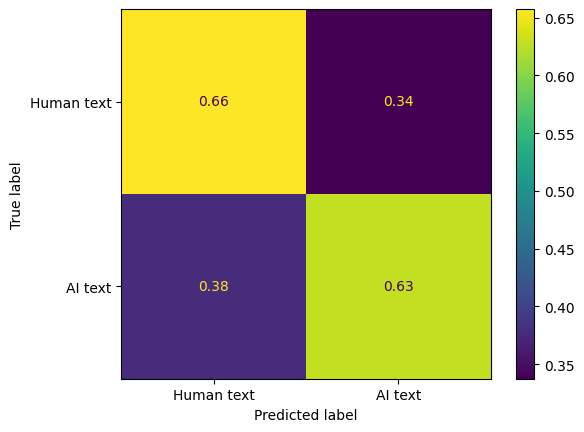

In [14]:
true_labels = np.array(actuals)
pred_labels = np.array(predictions)
C = confusion_matrix(true_labels,pred_labels)
C = C / C.astype(np.float).sum(axis=1)
disp = ConfusionMatrixDisplay(confusion_matrix=C ,display_labels=['Human text','AI text'])
disp.plot()

In [15]:
print('Accuracy is {}'.format(accuracy_score(true_labels,pred_labels)))

Accuracy is 0.6425
